In [1]:
#Import packages
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
import seaborn as sns

We assume that all students have a latent quality $W$, their scores $\hat{W^A},\hat{W^B}$ are respectively the rating scores of college A and B. These ratings scores are the sum of the latent quality and a noise term $\varepsilon$ drawn indepdently at each college, i.e. 
\begin{equation}
   \forall s \in S, \text{ for } C \in \{A,B\}, \widehat{W^C_s} = \varepsilon_s^C + W_s 
\end{equation}
where $S$ is the student set and $s$ is an arbitrary student. Moreover, we assume that the latent qualities of all students are drawn from a (group-indepedent) normal distribution, the noises are also normally distributed and depend on the group:
\begin{equation}
     \forall s \in S, \text{ for } C \in \{A,B\}, W_s \sim \mathcal{N}(0,\chi^2), \varepsilon^C_s \sim \mathcal{N}(0,\sigma^2_{G(s)}).
\end{equation}
$\hat{W}_s^C$ then is a normal distribution with mean $0$ and variance $\chi_{G(s)}^2 = \chi^2 + \sigma^2_{G(s)}$.

In this notebook, we will calculate the conditional expectation $E[W_s|\widehat{W_s^A},\widehat{W_s^B}<P_B]$. 

This conditional expectation can be rewritten as

$$E[W_s|\widehat{W_s^A},\widehat{W_s^B}<P_B] = \int_R w \frac{f_{W_s,\widehat{W_s^A},\widehat{W_s^B} < P_B}(w,w_A,w_B < P_B)}{f_{\widehat{W_s^A},\widehat{W_s^B} < P_B}(w_A,w_B < P_B)} dw$$

The joint distribution in the numerator $f_{W_s,\widehat{W_s^A},\widehat{W_s^B} < P_B}(w,w_A,w_B < P_B)$ can be rewritten as 

$$f_{W_s,\widehat{W_s^A},\widehat{W_s^B} < P_B}(w,w_A,w_B < P_B) = \phi(\frac{w_A - w}{\sigma_{G(s)}}) \Phi(\frac{P_B- w}{\sigma_{G(s)}}) \phi(\frac{w}{\chi})$$

where $\phi,\Phi$ are respectively the pdf and cdf of the standard normal distribution variable $Z$. 

Thus we define the following function to calculate this joint distribution


In [2]:
def joint_dist(w,w_a,p_b,chi,sigma):
    return norm.pdf(w,0,chi)*norm.pdf((w_a - w),0,sigma)*norm.cdf((p_b-w),0,sigma)

Using the fact that $(\widehat{W_s^A},\widehat{W_s^B})$ is joint Gaussian, the joint distribution $f_{\widehat{W_s^A},\widehat{W_s^B} < P_B}(w_A,w_B < P_B)$ in the denominator can be rewritten as

$$f_{\widehat{W_s^A},\widehat{W_s^B} < P_B}(w_A,w_B < P_B) = f_{\widehat{W_s^B} < P_B|\widehat{W^A_s}}(w_B < P_B|w_A) f_{\widehat{W^A_s}}(w_A).$$

We therefore define the following function to calculate the joint distribution $f_{\widehat{W_s^A},\widehat{W_s^B} < P_B}(w_A,w_B < P_B)$

In [9]:
def gaussian_denominator(w_a,P_B,chi,sigma):
    mean_cond_dist = chi**2/(chi**2 + sigma**2)*w_a
    var_cond_dist = (sigma**4 + 2*sigma**2*chi**2)/(chi**2 + sigma**2)
    return norm.cdf(P_B,mean_cond_dist,np.sqrt(var_cond_dist))*norm.pdf(w_a,0,np.sqrt(sigma**2 + chi**2))

We generate $W$ and $\varepsilon_A,\varepsilon_B$ according to Gaussian distributions. 

In [6]:
#Generate data, return data and the parameter chi, sigma
def data_generator(chi=4,sigma=2,n=100000):
    #Generate value
    W = np.random.normal(0,chi,n)
    epsilon_a = np.random.normal(0,sigma,n)
    epsilon_b = np.random.normal(0,sigma,n)
    W_A = W + epsilon_a
    W_B = W + epsilon_b
    #Generate cutoff value of College B (Here we choose 75 percentile)
    P_B = np.percentile(W_B,75)
    return W,W_A,W_B,P_B,chi,sigma


In [7]:
#Randomized a student
def randomized_student(W,W_A):
    #Select a random student
    student_index = np.random.randint(0,9999)
    w = W[student_index]
    w_a = W_A[student_index]
    return student_index,w,w_a

In [7]:
W,W_A,W_B,P_B,chi,sigma = data_generator(n=1000000)
student_index,w,w_a = randomized_student(W,W_A)
joint_distribution = joint_dist(W,w_a,P_B,chi,sigma)

In [18]:

P_B = -100
h = 1e-1
test_w = W[(W_A < w_a + h)& (W_A > w_a - h)&(W_B < P_B)]
len(test_w)

0

In [19]:
w = np.arange(-15,15,0.1)
joint_distribution = joint_dist(w,w_a,P_B,chi,sigma)
cond_distribution = joint_dist(w,w_a,P_B,chi,sigma)/gaussian_denominator(w_a,P_B,chi,sigma)

/tmp/ipykernel_16580/1832840254.py:3: RuntimeWarning: invalid value encountered in divide
  cond_distribution = joint_dist(w,w_a,P_B,chi,sigma)/gaussian_denominator(w_a,P_B,chi,sigma)


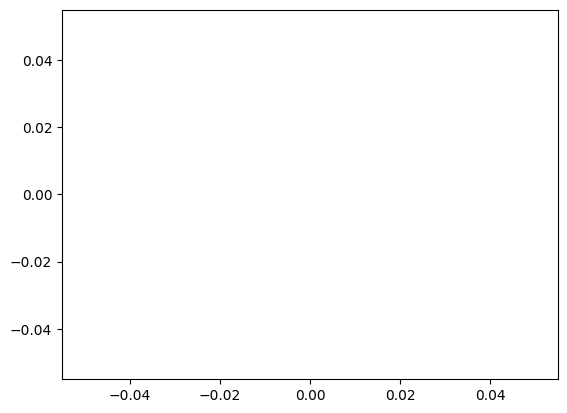

In [20]:
plt.figure()
plt.plot(w,cond_distribution)
sns.kdeplot(test_w)
#ax = plt.gca()


plt.show()

Here we make the assumption that both scores are Gaussian thus their joint distribution is a bivariate Gaussian distribution. The Gaussian denominator can be calculated as

In [130]:
def gaussian_denominator(w_a,P_B,chi,sigma):
    std = np.sqrt(chi**2 + sigma**2)
    transformed_P_B = (std*P_B - chi**2*w_a/std)/(np.sqrt(sigma**4 + 2*sigma**2*chi**2))
    return norm.pdf(w_a,0,std)*norm.cdf(transformed_P_B)


In [12]:
def gaussian_denominator(w_a,P_B,chi,sigma):
    mean_cond_dist = chi**2/(chi**2 + sigma**2)*w_a
    var_cond_dist = (sigma**4 + 2*sigma**2*chi**2)/(chi**2 + sigma**2)
    return norm.cdf(P_B,mean_cond_dist,np.sqrt(var_cond_dist))*norm.pdf(w_a,0,np.sqrt(sigma**2 + chi**2))

In [1]:
P_B = 10
h = 1e-1
test_w_a = W_A[W_B < P_B]

NameError: name 'W_A' is not defined

In [183]:
val_w_a = np.arange(-20,20,0.1)
cond_distribution_w_a = gaussian_denominator(val_w_a,P_B,chi,sigma)/norm.cdf(P_B/(np.sqrt(sigma**2 + chi**2)))

<Axes: >

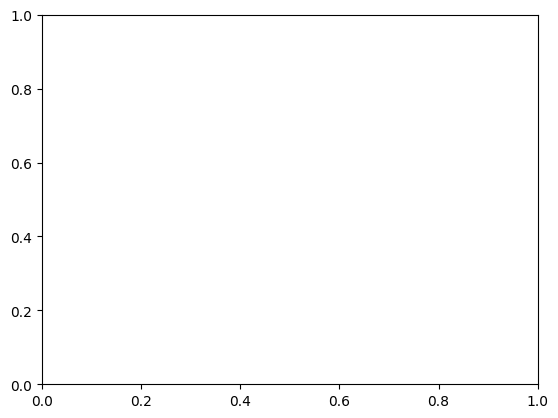

In [184]:
sns.kdeplot(test_w_a)

In [186]:
a = np.random.normal(0,2,1)

In [188]:
norm.pdf(a,0,2)

array([0.19444442])

In [189]:
norm.pdf(a/2)

array([0.38888884])

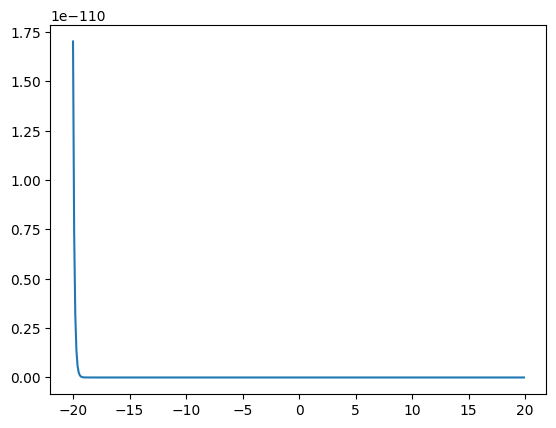

In [185]:
plt.plot(val_w_a,cond_distribution_w_a)


In [102]:
a = np.random.normal(0,1,1000)

<Axes: ylabel='Density'>

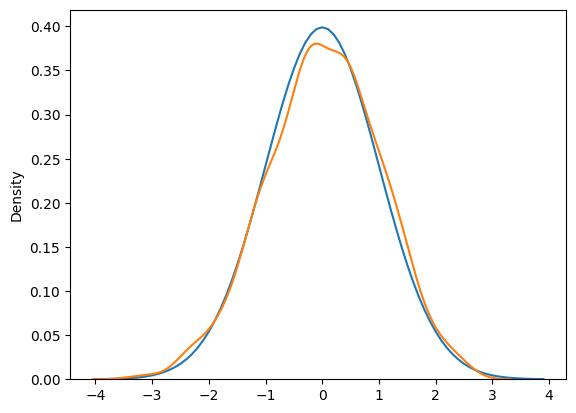

In [123]:
t = np.arange(-4,4,0.1)
p = norm.pdf(t)
plt.plot(t,p)
sns.kdeplot(a)

We calculate the numerator of the Bayesian Optimal algorithm using numerical integration

In [12]:
def integrand(w,w_a,p_b,chi,sigma):
    return w*norm.pdf(w,0,chi)*norm.pdf((w_a - w),0,sigma)*norm.cdf((p_b-w),0,sigma)#/gaussian_denominator(w_a,p_b,chi,sigma)

In [13]:
def exp_val(w_a,p_b,chi,sigma):
    return quad(integrand, -np.inf,np.inf,args=(w_a,p_b,chi,sigma))

In [14]:
exp_val(w_a,-100,chi,sigma)

(-0.00015357282636563275, 7.621540641869219e-09)

The Bayesian Optimal estimator will be


In [150]:
exp_val(w_a,P_B,chi,sigma)[0]/gaussian_denominator(w_a,P_B,chi,sigma)

17.612205870410396

The one sided Bayesian Optimal estimator is defined as the conditional of the true value on the observed rating.

In [17]:
def bayesian_naive(w_a,chi,sigma):
    return chi**2/(chi**2+sigma**2)*w_a

Experiment

In [96]:
W,W_A,W_B,P_B,chi,sigma = data_generator(sigma=10000,chi=1)
student_index,w,w_a = randomized_student(W,W_A)
w_a = 10
P_B = 10000
joint_distribution = joint_dist(W,w_a,P_B,chi,sigma)

In [70]:
exp_val(w_a,0,chi,sigma)[0]

-3.354511308129001e-06

In [97]:
bayesian_naive(w_a,chi,sigma)

9.9999999e-08

In [68]:
gaussian_denominator(w_a,0,chi,sigma)

1.443519995805643e-05

In [91]:
exp_val(w_a,P_B,chi,sigma)[0]/gaussian_denominator(w_a,P_B,chi,sigma)


-2.866003150746514e-05

<function __main__.bayesian_naive(w_a, chi, sigma)>

In [79]:
baye2

[-7.984722431716025e-05,
 -7.984085604126008e-05,
 -7.983448798326889e-05,
 -7.982812014320056e-05,
 -7.982175252105286e-05,
 -7.981538511685032e-05,
 -7.980901793061018e-05,
 -7.980265096233084e-05,
 -7.97962842120541e-05,
 -7.978991767975267e-05,
 -7.97835513654276e-05,
 -7.977718526915744e-05,
 -7.977081939090485e-05,
 -7.976445373065471e-05,
 -7.975808828850024e-05,
 -7.97517230643767e-05,
 -7.974535805834376e-05,
 -7.973899327034403e-05,
 -7.973262870051481e-05,
 -7.972626434873682e-05,
 -7.971990021508275e-05,
 -7.97135362996076e-05,
 -7.970717260221272e-05,
 -7.970080912299254e-05,
 -7.969444586193002e-05,
 -7.968808281902116e-05,
 -7.968171999435671e-05,
 -7.967535738782447e-05,
 -7.966899499953946e-05,
 -7.966263282945832e-05,
 -7.96562708776167e-05,
 -7.96499091440246e-05,
 -7.964354762867709e-05,
 -7.963718633159692e-05,
 -7.963082525280024e-05,
 -7.962446439228896e-05,
 -7.961810375008823e-05,
 -7.961174332619024e-05,
 -7.960538312060728e-05,
 -7.959902313337208e-05,
 -7.95

In [82]:
p = np.arange(-10,10000,1)
baye2 = [exp_val(w_a,p,chi,sigma)[0]/gaussian_denominator(w_a,p,chi,sigma) for p in p]


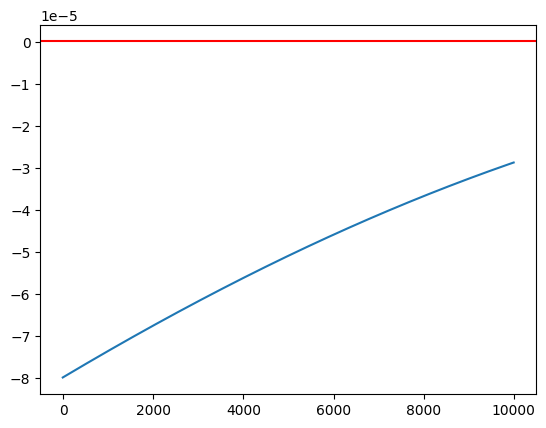

In [83]:
plt.plot(p,baye2)
plt.axhline(y=bayesian_naive(w_a,chi,sigma), color='r', linestyle='-')